In [1]:
import numpy as np
import pandas as pd
import os, sys, re, ast, csv, math, gc, random, enum, argparse, json, requests, time  
from datetime import datetime, timedelta
import matplotlib.pyplot as plt 
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None) # to ensure console display all columns
pd.set_option('display.float_format', '{:0.3f}'.format)
pd.set_option('display.max_row', 40)
plt.style.use('ggplot')
from pathlib import Path
import joblib
from joblib import dump, load
from copy import deepcopy


dataPath = Path(r'/run/media/yen/MLData/MLProjects/UW_Insurance_Churn_Analysis/data')
pickleDataPath = dataPath / 'pickle'
dataInputPath = dataPath / 'input'
dataWorkingPath = dataPath / 'working'  
data_df = pd.read_excel(dataInputPath / "PoliciesFinal.xlsb", engine='pyxlsb')


It seems that pol_eff_date >= ACTIVEDATE >= QUOTEDATE.
We will use pol_eff_date as the effective policy start date.

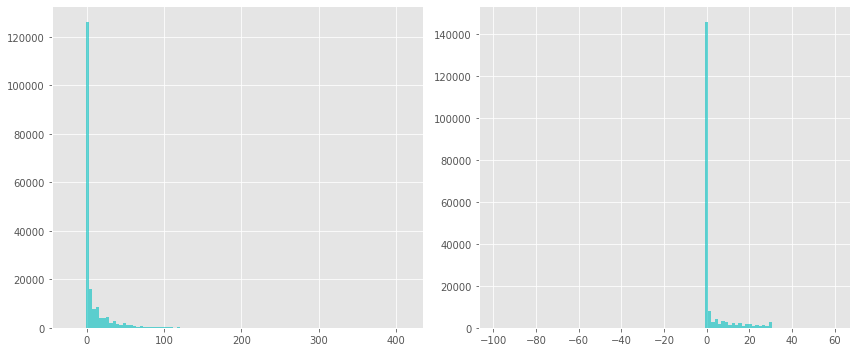

In [2]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
axes[0].hist(data_df['ACTIVEDATE'] - data_df['QUOTEDATE'], bins=100, color='c', alpha=0.6)
axes[1].hist(data_df['pol_eff_date'] - data_df['ACTIVEDATE'], bins=100, color='c', alpha=0.6)
fig.tight_layout()

Date values are excel date numbers, and need to be converted to dates. 
event_date > 400 is associated to non-inforce status. We shall define churn target as those that Lapsed or Lapsed (No Reinstatement) 

In [3]:
data_df.loc[data_df['event_date'] > 400, 'status'].value_counts()

Lapsed                        33254
Expiry                         1230
Claim Paid                      880
Cancelled (from inception)      187
Not Taken up                    138
Claim Notified                   99
Death Notified                    3
Lapsed (No Reinstatement)         2
Name: status, dtype: int64

Given that distribution of POLTERM have spike at round numbers (10, 20, 30 etc), most likely it is the policy length determine at start

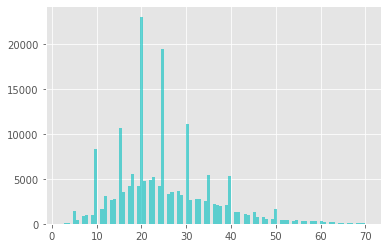

In [4]:
_ = plt.hist(data_df.loc[data_df['POLTERM']<100,'POLTERM'], bins=100, color='c', alpha=0.6)

In [5]:
# Convert date columns from excel number to date
def convert_excel_date_to_date(excel_date):
    return datetime.fromordinal(datetime(1900, 1, 1).toordinal() + excel_date - 2).date()
cols_date = ['QUOTEDATE','ACTIVEDATE','pol_eff_date','index_change','event_date']
for col in cols_date:
    data_df[col] = data_df[col].apply(lambda d: convert_excel_date_to_date(d))

It seems a good snapshot date list for analysis is 2016-06-30, 2017-06-30, and 2018-06-30.
We shall create 3 data sets:
1. Dataset A containing all inforce policies as at 2016-06-30, with target label as those who churn between 2016-07-01 to 2017-06-30, where churn are those that Lapsed or Lapsed (No Reinstatement).
2. Dataset B containing all inforce policies as at 2017-06-30, with target label as those who churn between 2017-07-01 to 2018-06-30
3. Dataset B containing all inforce policies as at 2018-06-30, with target label as those who churn between 2018-07-01 to 2018-10-31

This means that we will have 2 datasets for evaluating results: <br>
1. We will first train the models on Dataset A, and using these models to make predictions on Dataset B, and then evaluate the model performance. <br>
2. Then we train the models on Dataset B, and using these models to make predictions on Dataset C, and then evaluate the model performance. <br>
3. The overall model performance will be the aggregated performance across the 2 test datasets.

In [6]:
print(f"pol_eff_date min: {data_df['pol_eff_date'].min()}")
print(f"pol_eff_date max: {data_df['pol_eff_date'].max()}")

print(f"event_date min: {data_df.loc[data_df['event_date'] > pd.to_datetime('1901-01-01').date(), 'event_date'].min()}")
print(f"event_date max: {data_df.loc[data_df['event_date'] > pd.to_datetime('1901-01-01').date(), 'event_date'].max()}")

pol_eff_date min: 2008-07-08
pol_eff_date max: 2016-06-30
event_date min: 2016-07-01
event_date max: 2018-10-31


Other observations/notes: <br>
1. If JOINTLIFE is 'S', i.e. single, then gender2 = SMOKER2 = Null, else gender2 & SMOKER2 will have values
<br>
2. Date values are excel date numbers, and need to be converted to dates
<br>
3. We will infer date of birth by making the assumption that the age in the data-set is as at '2019-12-31'
<br>
4. We will remove redundant columns: <br>
    a. TIGOPTION: all rows have value 'N' <br>
    b. entry_age1, entry_age2, AGEMTHADJ1, AGEMTHADJ2, since age_life1 ~= entry_age1 + AGEMTHADJ1 / 12 <br>
<br>    
5. We will not use the following columns as features: <br>
    a. index_change and index_status, as it is unclear whether index_status contains direct information about the policy status <br>
    b. active_distributor, as it is unclear when an active distributor ceases to be active <br>
    c. current_sum_assured, as it is unclear when the policy holder made the top-ups/changes <br>
    d. ADDPOLMTHS, as it is unclear when the policy holder have decide to add additional term to policy <br>
<br>    
6. Categorical features used: <br>
    6.1 COMM_STYLE <br>
    6.2 CLAWBACK_STYLE <br>
    6.3 REGION <br>
    6.4 BENEFITCODE <br>
    6.5 gender1 <br>
    6.6 SMOKER1 <br>
    6.7 gender2 <br>
    6.8 SMOKER2 <br>
    6.9 occ_class <br>
    6.10 JOINTLIFE <br>
    6.11 BENESC <br>
    6.12 PRODCODE <br>
    6.13 prem_freq <br>
    6.14 product <br>
    6.15 rated <br>   
<br>    
7. Numerical features used: <br>
    7.1 initial_sum_assured <br>
    7.2 POLTERM <br>
    7.3 UWLDPERML1_MORT <br>
    7.4 UWLDPERML2_MORT <br>
    7.5 UWPERMILL1_MORT <br>
    7.6 UWPERMILL2_MORT <br>
    7.7 age_life1 <br>
    7.8 age_life2 <br>
    7.9 pol_tenure <br>


In [7]:
cols_redundant = ['TIGOPTION','entry_age1','entry_age2','AGEMTHADJ1','AGEMTHADJ2']

cols_not_usable = ['index_change','index_status','active_distributor','QUOTEDATE','ACTIVEDATE','current_sum_assured','ADDPOLMTHS']

col_cat = ['COMM_STYLE','CLAWBACK_STYLE','REGION','BENEFITCODE',
           'gender1','SMOKER1','gender2','SMOKER2','occ_class','JOINTLIFE',
           'BENESC','PRODCODE','prem_freq','product','rated']

col_num = ['initial_sum_assured','POLTERM','UWLDPERML1_MORT','UWLDPERML2_MORT','UWPERMILL1_MORT','UWPERMILL2_MORT','age_life1','age_life2','pol_tenure']
col_id = 'id'
col_target = 'target'

# We define the churn target as those who Lapsed or Lapsed (No Reinstatement)  
churn_status_list = ['Lapsed','Lapsed (No Reinstatement)']

# Infer DOB
cur_date = pd.to_datetime('2019-12-31').date()
def get_dob(age):
    if age == 0:
        return pd.NaT
    else:
        return cur_date - timedelta(days = int(np.floor(age*365.25)))
    
def get_age(dob, snapshot_date):
    if pd.isna(dob):
        return 0
    else:
        return np.round((pd.to_datetime(cur_snapshot_date).date() - dob).days / 365.25, 2)
   
data_df['dob1'] = data_df['age_life1'].apply(lambda age: get_dob(age)) 
data_df['dob2'] = data_df['age_life2'].apply(lambda age: get_dob(age)) 
data_df.drop(['age_life1', 'age_life2'], axis=1, inplace=True)     


It seems that as at 2016-06-30, there are 188,410 inforce policies, of which 15,847 (8.4%) churned within the next year. <br>
As at 2017-06-30, there are 171,482 inforce policies, of which 13,471 (7.9%) churned within the next year. <br>
As at 2018-06-30, there are 156,931 inforce policies, of which 3,938 (2.5%) churned within the next 4 months. <br>
Hence, the year-on-year churn rate is quite stable, albeit slightly decreasing each year


In [8]:
snapshot_date_list = ['2016-06-30','2017-06-30','2018-06-30','2018-10-31'] 

for cur_snapshot_date, next_snapshot_date in zip(snapshot_date_list[:-1], snapshot_date_list[1:]):
    # Get available policies as at cur_snapshot_date. 
    data_df_snapshot = data_df[data_df['pol_eff_date'] <= pd.to_datetime(cur_snapshot_date).date()].copy()
    
    # Remove policies that are not inforce as at cur_snapshot_date
    idx = (data_df_snapshot['event_date'] > pd.to_datetime('1901-01-01').date()) & (data_df_snapshot['event_date'] <= pd.to_datetime(cur_snapshot_date).date())
    data_df_snapshot = data_df_snapshot.loc[~idx]
    data_df_snapshot.reset_index(drop=True, inplace=True)


    # Those that Lapsed between (cur_snapshot_date, next_snapshot_date] are the targets
    idx_date = (data_df_snapshot['event_date'] > pd.to_datetime(cur_snapshot_date).date()) & (data_df_snapshot['event_date'] <= pd.to_datetime(next_snapshot_date).date())
    idx_lapse = data_df_snapshot['status'].isin(churn_status_list)

    # target
    data_df_snapshot[col_target] = 0
    data_df_snapshot.loc[idx_date & idx_lapse, col_target] = 1

    # Estimating age as at cur_snapshot_date
    data_df_snapshot['age_life1'] = data_df_snapshot['dob1'].apply(lambda dob: get_age(dob, snapshot_date=cur_snapshot_date))
    data_df_snapshot['age_life2'] = data_df_snapshot['dob2'].apply(lambda dob: get_age(dob, snapshot_date=cur_snapshot_date))

    # Estimating policy tenure
    data_df_snapshot['pol_tenure'] = data_df_snapshot['pol_eff_date'].apply(lambda dob: get_age(dob, snapshot_date=cur_snapshot_date))

    n_record = len(data_df_snapshot)
    n_target = data_df_snapshot[col_target].sum()
    data_df_snapshot.drop(['pol_eff_date','event_date','dob1','dob2','status','inforce'], axis=1, inplace=True)

    data_df_snapshot.to_csv(os.path.join(dataWorkingPath / f"model_data_{cur_snapshot_date}.csv"), index=False) 
    print(f"cur_snapshot_date: {cur_snapshot_date}, n_record: {n_record:,.0f}, n_target: {n_target:,.0f}, target_pct: {n_target/n_record:,.3f}")


cur_snapshot_date: 2016-06-30, n_record: 188,410, n_target: 15,847, target_pct: 0.084
cur_snapshot_date: 2017-06-30, n_record: 171,482, n_target: 13,471, target_pct: 0.079
cur_snapshot_date: 2018-06-30, n_record: 156,931, n_target: 3,938, target_pct: 0.025
